<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Multivariate time series

---

So far we have looked at univariate time series, the time dependence of a single variable. In multivariate time series one considers how several variables change together with time. Practical use cases are portfolios of stocks or price indices.

If we want to preserve stationarity like in the univariate case, we require constant mean for all variables, but additionally constancy of the covariance matrix of all variables over time and that there are no correlations between the variables across different times.

Then we can build ARIMA models like before:


$$y_t = \mu + A_1 y_{t-1} + \dots + A_p y_{t-p} + \epsilon_t +
    M_1 \epsilon_{t-1} + \dots M_q \epsilon_{t-q}$$

where $\epsilon_t \sim N(0, \Omega)$. $y_t$ and $\epsilon_t$ are vectors with as many entries as we have variables, and $A_i$ and $M_i$ are quadratic matrices with as many rows and columns as variables. 

In the multivariate case we speak of VARMA models. They are implemented in the VARMAX class in Statsmodels.

In [1]:
# this will filter out a lot of future warnings from statsmodels
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from dateutil.relativedelta import relativedelta

sns.set(font_scale=1.5)
plt.style.use('fivethirtyeight')
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [3]:
from scipy import stats
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, pacf, ccf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

#### Let's look at an example which combines time series for consumer price indices and industrial production rates.

In [4]:
data = sm.datasets.macrodata
df = data.load_pandas().data

In [5]:
print(data.NOTE)

::
    Number of Observations - 203

    Number of Variables - 14

    Variable name definitions::

        year      - 1959q1 - 2009q3
        quarter   - 1-4
        realgdp   - Real gross domestic product (Bil. of chained 2005 US$,
                    seasonally adjusted annual rate)
        realcons  - Real personal consumption expenditures (Bil. of chained
                    2005 US$, seasonally adjusted annual rate)
        realinv   - Real gross private domestic investment (Bil. of chained
                    2005 US$, seasonally adjusted annual rate)
        realgovt  - Real federal consumption expenditures & gross investment
                    (Bil. of chained 2005 US$, seasonally adjusted annual rate)
        realdpi   - Real private disposable income (Bil. of chained 2005
                    US$, seasonally adjusted annual rate)
        cpi       - End of the quarter consumer price index for all urban
                    consumers: all items (1982-84 = 100, seasonally adju

In [6]:
df.head()

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
0,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.98,139.7,2.82,5.8,177.146,0.00,0.00
1,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.15,141.7,3.08,5.1,177.830,2.34,0.74
2,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.35,140.5,3.82,5.3,178.657,2.74,1.09
3,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.37,140.0,4.33,5.6,179.386,0.27,4.06
4,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.54,139.6,3.50,5.2,180.007,2.31,1.19


In [7]:
df.tail()

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
198,2008.0,3.0,13324.600,9267.7,1990.693,991.551,9838.3,216.889,1474.7,1.17,6.0,305.270,-3.16,4.33
199,2008.0,4.0,13141.920,9195.3,1857.661,1007.273,9920.4,212.174,1576.5,0.12,6.9,305.952,-8.79,8.91
200,2009.0,1.0,12925.410,9209.2,1558.494,996.287,9926.4,212.671,1592.8,0.22,8.1,306.547,0.94,-0.71
201,2009.0,2.0,12901.504,9189.0,1456.678,1023.528,10077.5,214.469,1653.6,0.18,9.2,307.226,3.37,-3.19
202,2009.0,3.0,12990.341,9256.0,1486.398,1044.088,10040.6,216.385,1673.9,0.12,9.6,308.013,3.56,-3.44


In [8]:
df.index = pd.date_range(start='1959-01-01', end='2009-09-30', freq='Q')

In [9]:
df.head()

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
1959-03-31,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.98,139.7,2.82,5.8,177.146,0.00,0.00
1959-06-30,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.15,141.7,3.08,5.1,177.830,2.34,0.74
1959-09-30,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.35,140.5,3.82,5.3,178.657,2.74,1.09
1959-12-31,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.37,140.0,4.33,5.6,179.386,0.27,4.06
1960-03-31,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.54,139.6,3.50,5.2,180.007,2.31,1.19


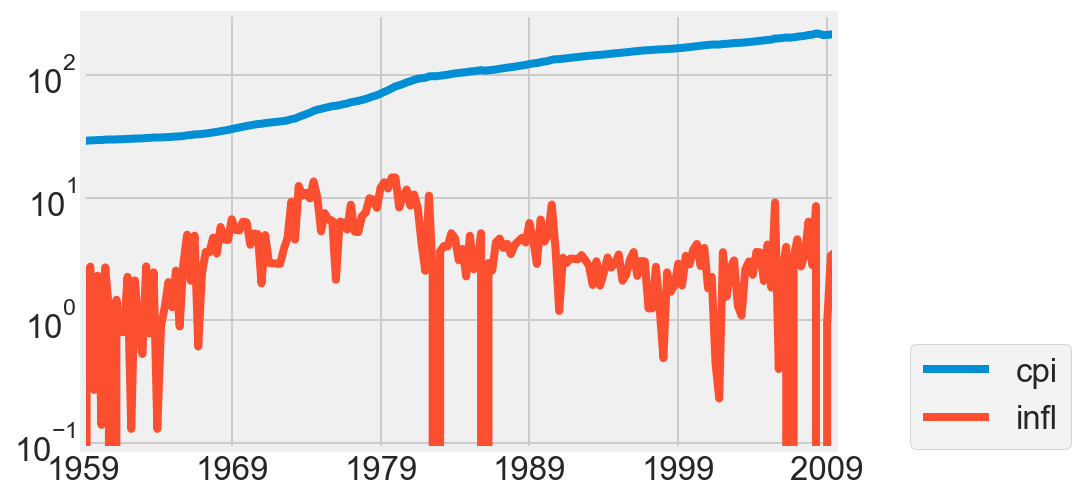

In [10]:
df[['cpi', 'infl']].plot(logy=True)
plt.legend(loc=[1.1, 0])
plt.show()

#### We use a log transform and differencing to make the time series stationary.

In [11]:
df_t = df[['cpi', 'infl']]

In [12]:
df_1 = df_t.diff()
df_1['cpi'] = df_1.cpi.diff()
df_1.dropna(inplace=True)

#### Let's visualise the time series.

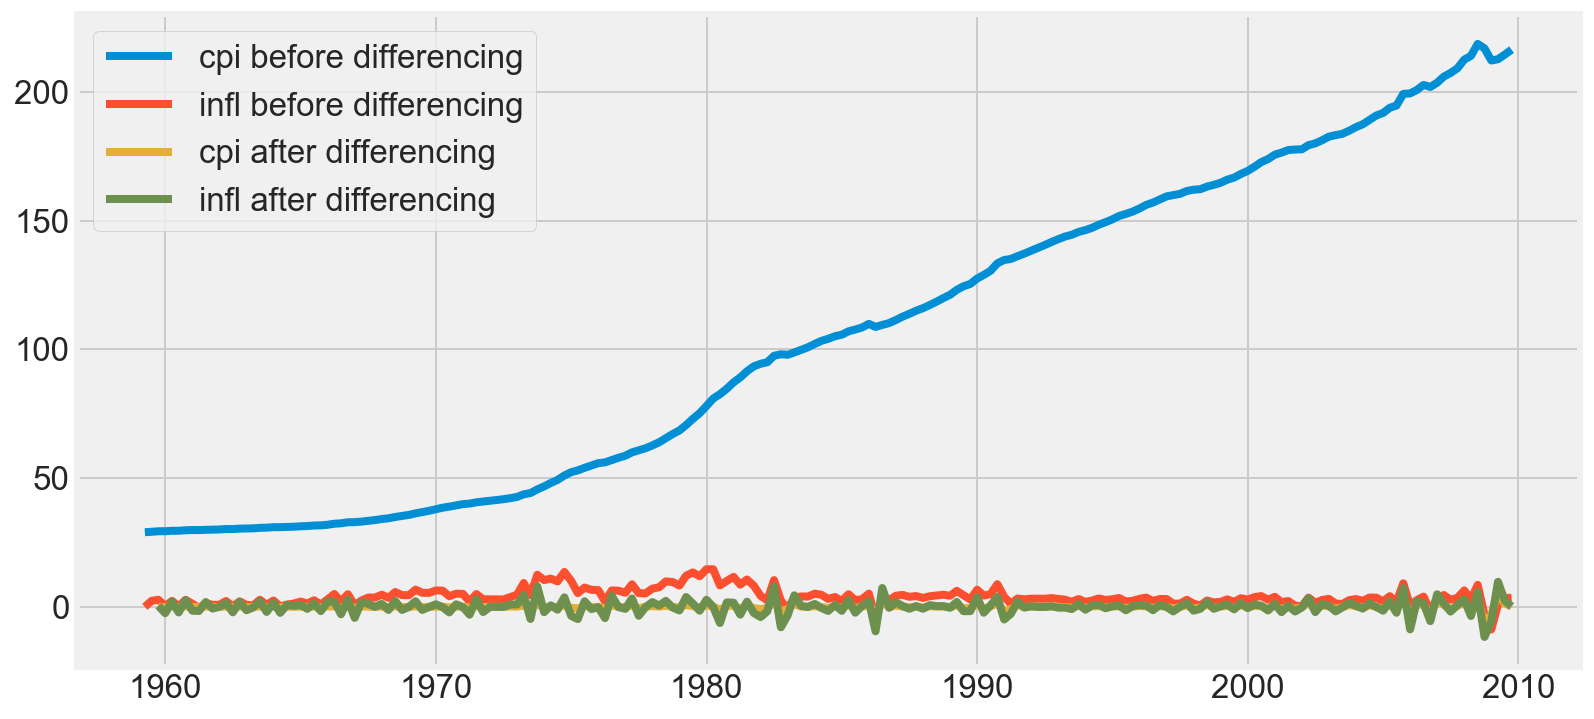

In [13]:
plt.figure(figsize=(12, 6))
plt.plot(df_t)
plt.plot(df_1)
plt.legend([df_t.columns[0]+' before differencing',
            df_t.columns[1]+' before differencing',
            df_t.columns[0]+' after differencing',
            df_t.columns[1]+' after differencing'], loc='upper left')

plt.show()

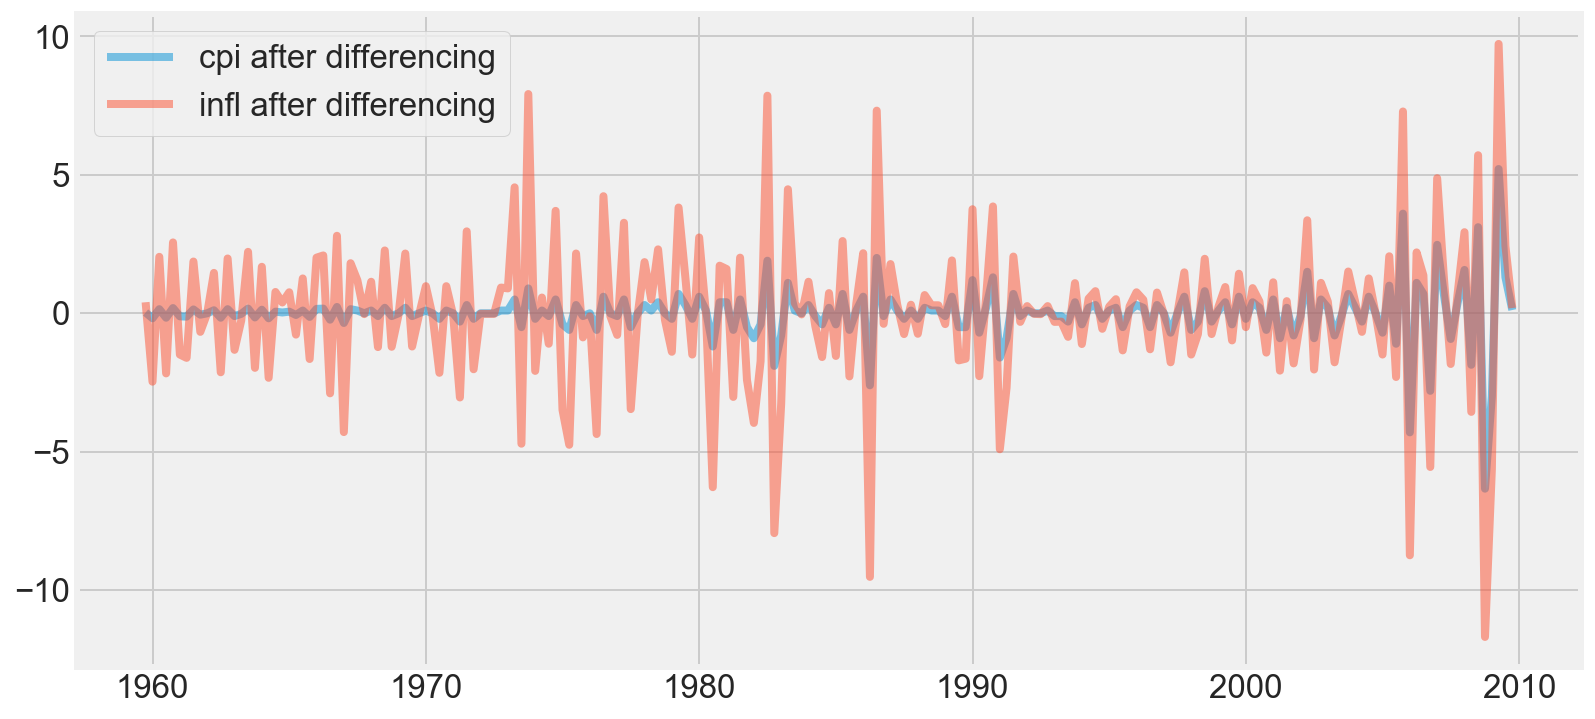

In [14]:
plt.figure(figsize=(12, 6))

plt.plot(df_1, alpha=0.5)
plt.legend([
            df_t.columns[0]+' after differencing',
            df_t.columns[1]+' after differencing'], loc='upper left')

plt.show()

#### We can look at the autocorrelations of each variable.

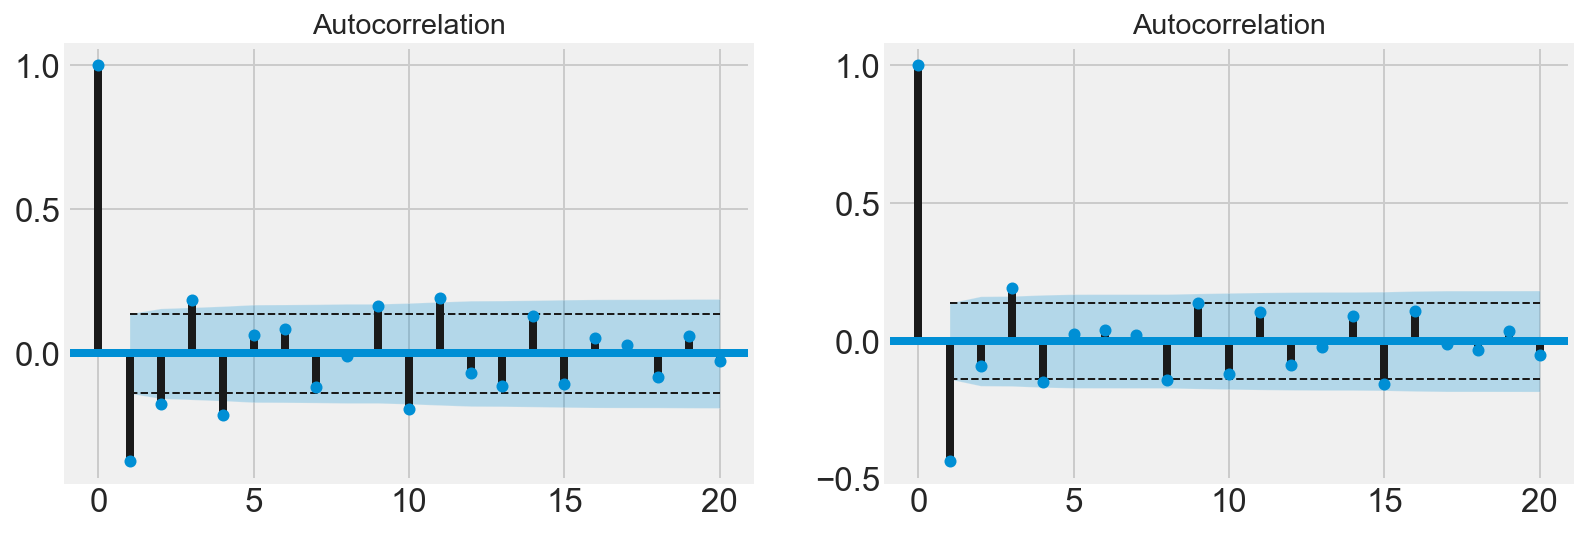

In [15]:
alpha = 0.05
se = stats.norm().ppf(1-alpha/2)/np.sqrt(len(df_1))

fig, ax = plt.subplots(ncols=2, figsize=(12, 4))
plot_acf(df_1.cpi, lags=20, ax=ax[0])
ax[0].hlines(np.array([-1, 1])*se, 1, 20, linestyles='--', lw=1)
plot_acf(df_1.infl, lags=20, ax=ax[1])
ax[1].hlines(np.array([-1, 1])*se, 1, 20, linestyles='--', lw=1)
plt.show()

#### We can look at the values of the cross correlation matrix at every lag.

**Note:** Cross correlations are not symmetric.

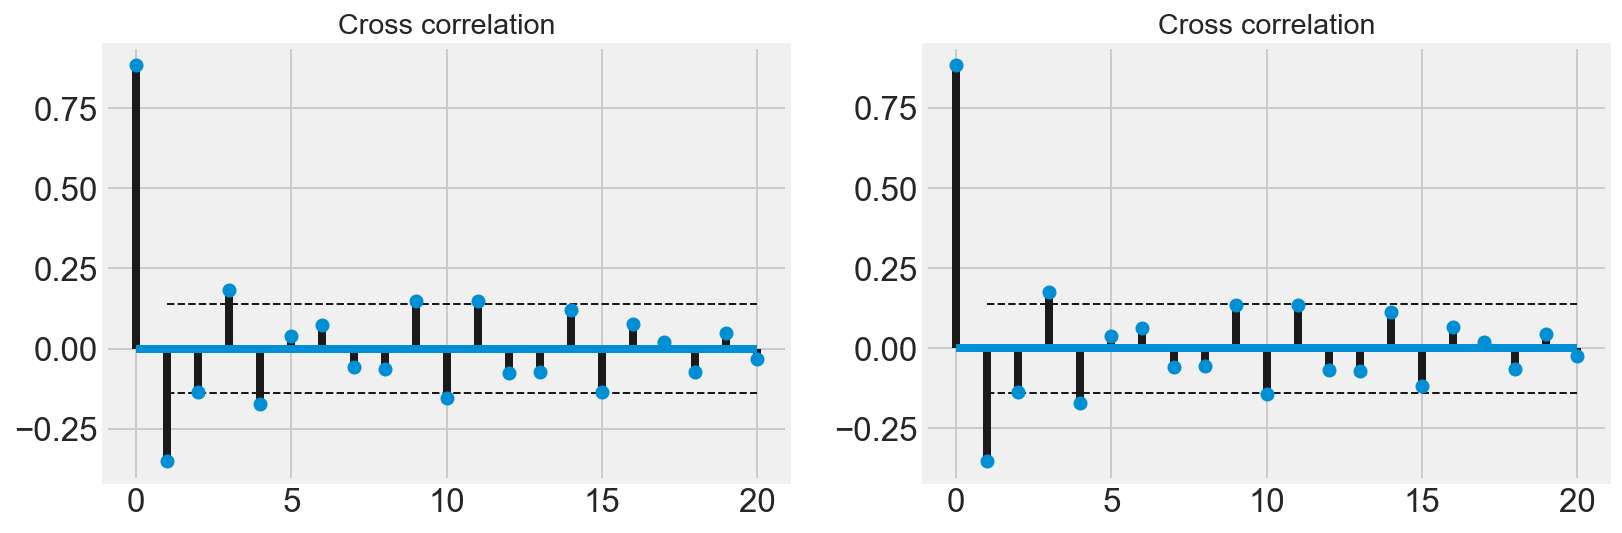

In [16]:
ccf_cpi_infl = ccf(df_1.cpi, df_1.infl)
ccf_infl_cpi = ccf(df_1.infl, df_1.cpi)

fig, ax = plt.subplots(ncols=2, figsize=(12, 4))
ax[0].stem(ccf_cpi_infl[:21], use_line_collection=True, linefmt='k', basefmt='')
ax[0].set_title('Cross correlation')
ax[0].hlines(np.array([-1, 1])*se, 1, 20, linestyles='--', lw=1)
ax[1].stem(ccf_infl_cpi[:21], use_line_collection=True, linefmt='k', basefmt='')
ax[1].set_title('Cross correlation')
ax[1].hlines(np.array([-1, 1])*se, 1, 20, linestyles='--', lw=1)
plt.show()

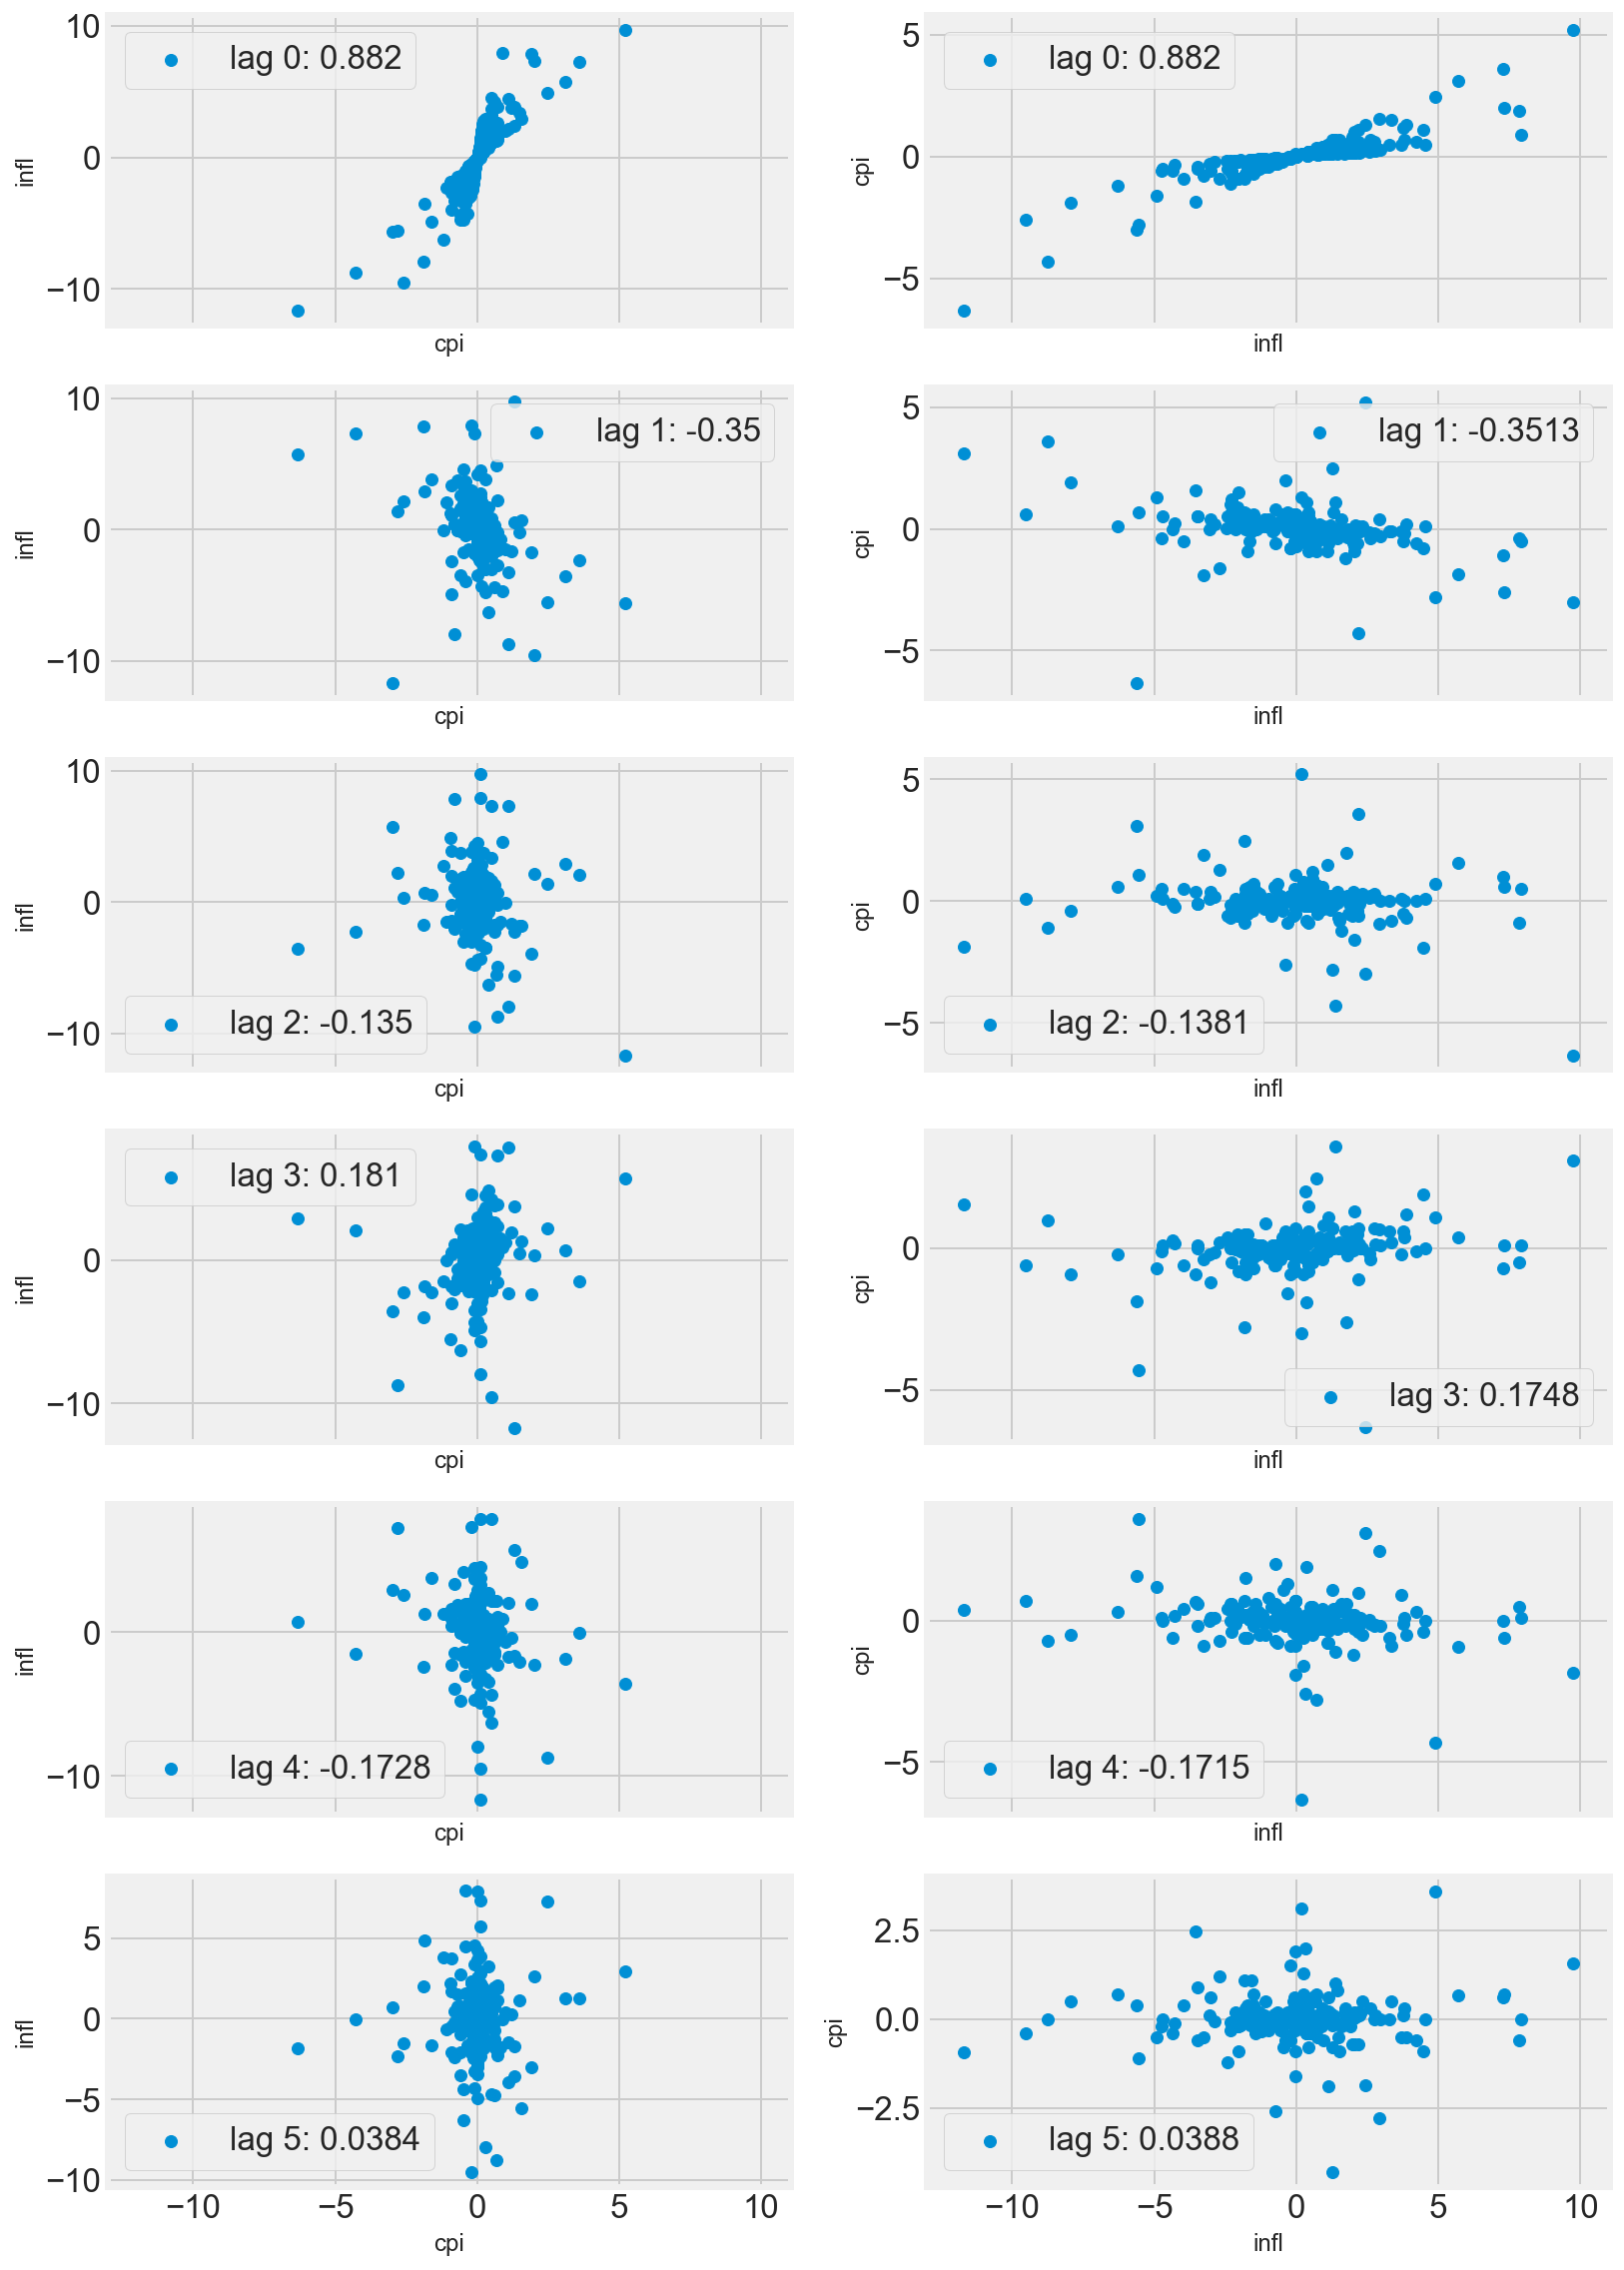

In [17]:
fig, ax = plt.subplots(nrows=6, ncols=2, sharex=True, figsize=(12, 20))
for i in range(0, ax.shape[0]):
    
    ax[i][0].scatter(df_1.iloc[i:]['cpi'], df_1['infl'].shift(i).dropna(), 
                    label=f'lag {i}: {round(ccf_cpi_infl[i], 4)}')
    ax[i][0].set_xlabel('cpi')
    ax[i][0].set_ylabel('infl')
    ax[i][0].legend()
    
    ax[i][1].scatter(df_1.iloc[i:]['infl'], df_1['cpi'].shift(i).dropna(), 
                    label=f'lag {i}: {round(ccf_infl_cpi[i], 4)}')
    ax[i][1].set_ylabel('cpi')
    ax[i][1].set_xlabel('infl')
    ax[i][1].legend()

plt.show()

#### Fitting a model is again very simple, we just need to indicate the order for $p$ and $q$. Now we get coefficient matrices for each AR term and each MA term.

In [18]:
model = sm.tsa.VARMAX(df_1, order=(1, 1), trend='c')
results = model.fit(maxiter=1000, disp=False)
results.summary()

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/varmax.py:152: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)


Dep. Variable:,"['cpi', 'infl']",No. Observations:,201
Model:,"VARMA(1,1)",Log Likelihood,-534.163
,+ intercept,AIC,1094.326
Date:,"Mon, 19 Aug 2019",BIC,1137.269
Time:,23:46:47,HQIC,1111.703
Sample:,09-30-1959,,
,- 09-30-2009,,
Covariance Type:,opg,,
Ljung-Box (Q):,"31.41, 73.72",Jarque-Bera (JB):,"2666.66, 100.39"
Prob(Q):,"0.83, 0.00",Prob(JB):,"0.00, 0.00"
Heteroskedasticity (H):,"18.43, 0.22",Skew:,"-1.60, 0.02"


#### We can extract the AR and MA coefficient matrices.

In [19]:
print(results.coefficient_matrices_var)

[[[ 0.59446991 -0.18687731]
  [ 1.93166949 -0.68898106]]]


In [20]:
print(results.coefficient_matrices_vma)

[[[-1.40697661  0.18005328]
  [-2.44786991  0.06913272]]]


#### Let's search for the best AR model according to AIC and BIC.

In [21]:
for i in range(1, 6):
    model = sm.tsa.VARMAX(df_1, order=(i, 0))
    results = model.fit(maxiter=1000, disp=False)
    print(i, results.aic, results.bic)

1 1169.5869832629178 1199.3167274354494
2 1132.4307849619026 1175.3737487666706
3 1137.4471611768763 1193.6033446138806
4 1110.8566611633432 1180.226064232584
5 1108.7997152739945 1191.3823379754713


In [22]:
model = sm.tsa.VARMAX(df_1, order=(1, 0))
results = model.fit(maxiter=1000, disp=False)

In [23]:
coeffs_ar = results.coefficient_matrices_var[0]
print(coeffs_ar)

[[-0.29457122 -0.03129657]
 [ 0.42122999 -0.56663847]]


#### Let's look at one particular model.

In [24]:
model = sm.tsa.VARMAX(df_1, order=(2, 0), trend='c')
results = model.fit(maxiter=1000, disp=False)

In [25]:
results.summary()

Dep. Variable:,"['cpi', 'infl']",No. Observations:,201
Model:,VAR(2),Log Likelihood,-553.215
,+ intercept,AIC,1132.431
Date:,"Mon, 19 Aug 2019",BIC,1175.374
Time:,23:46:50,HQIC,1149.807
Sample:,09-30-1959,,
,- 09-30-2009,,
Covariance Type:,opg,,
Ljung-Box (Q):,"41.44, 74.18",Jarque-Bera (JB):,"2227.61, 102.73"
Prob(Q):,"0.41, 0.00",Prob(JB):,"0.00, 0.00"
Heteroskedasticity (H):,"41.97, 0.21",Skew:,"-1.86, 0.03"


#### We can plot the residuals and obtain forecasts similar to the univariate case.

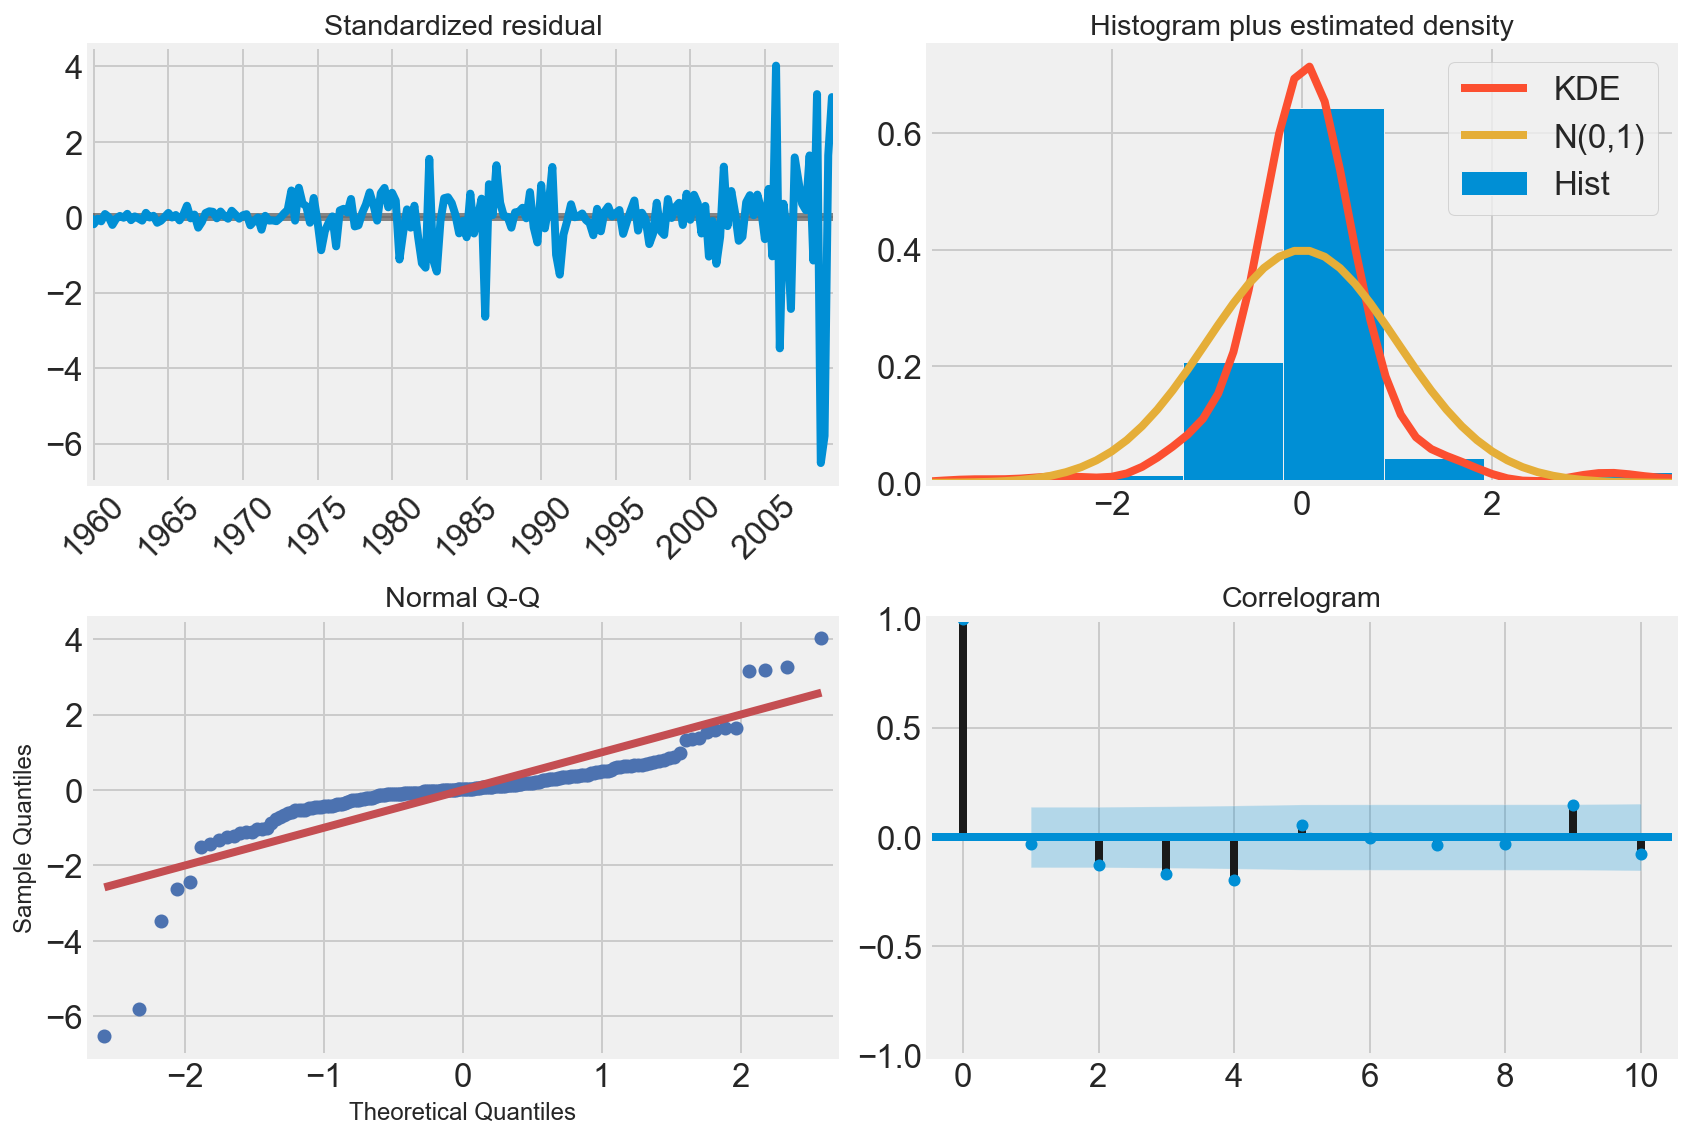

In [26]:
diag_plot = results.plot_diagnostics(0, figsize=(12, 8))
diag_plot.axes[0].tick_params(axis='x', labelrotation=45)
plt.tight_layout()
plt.show()

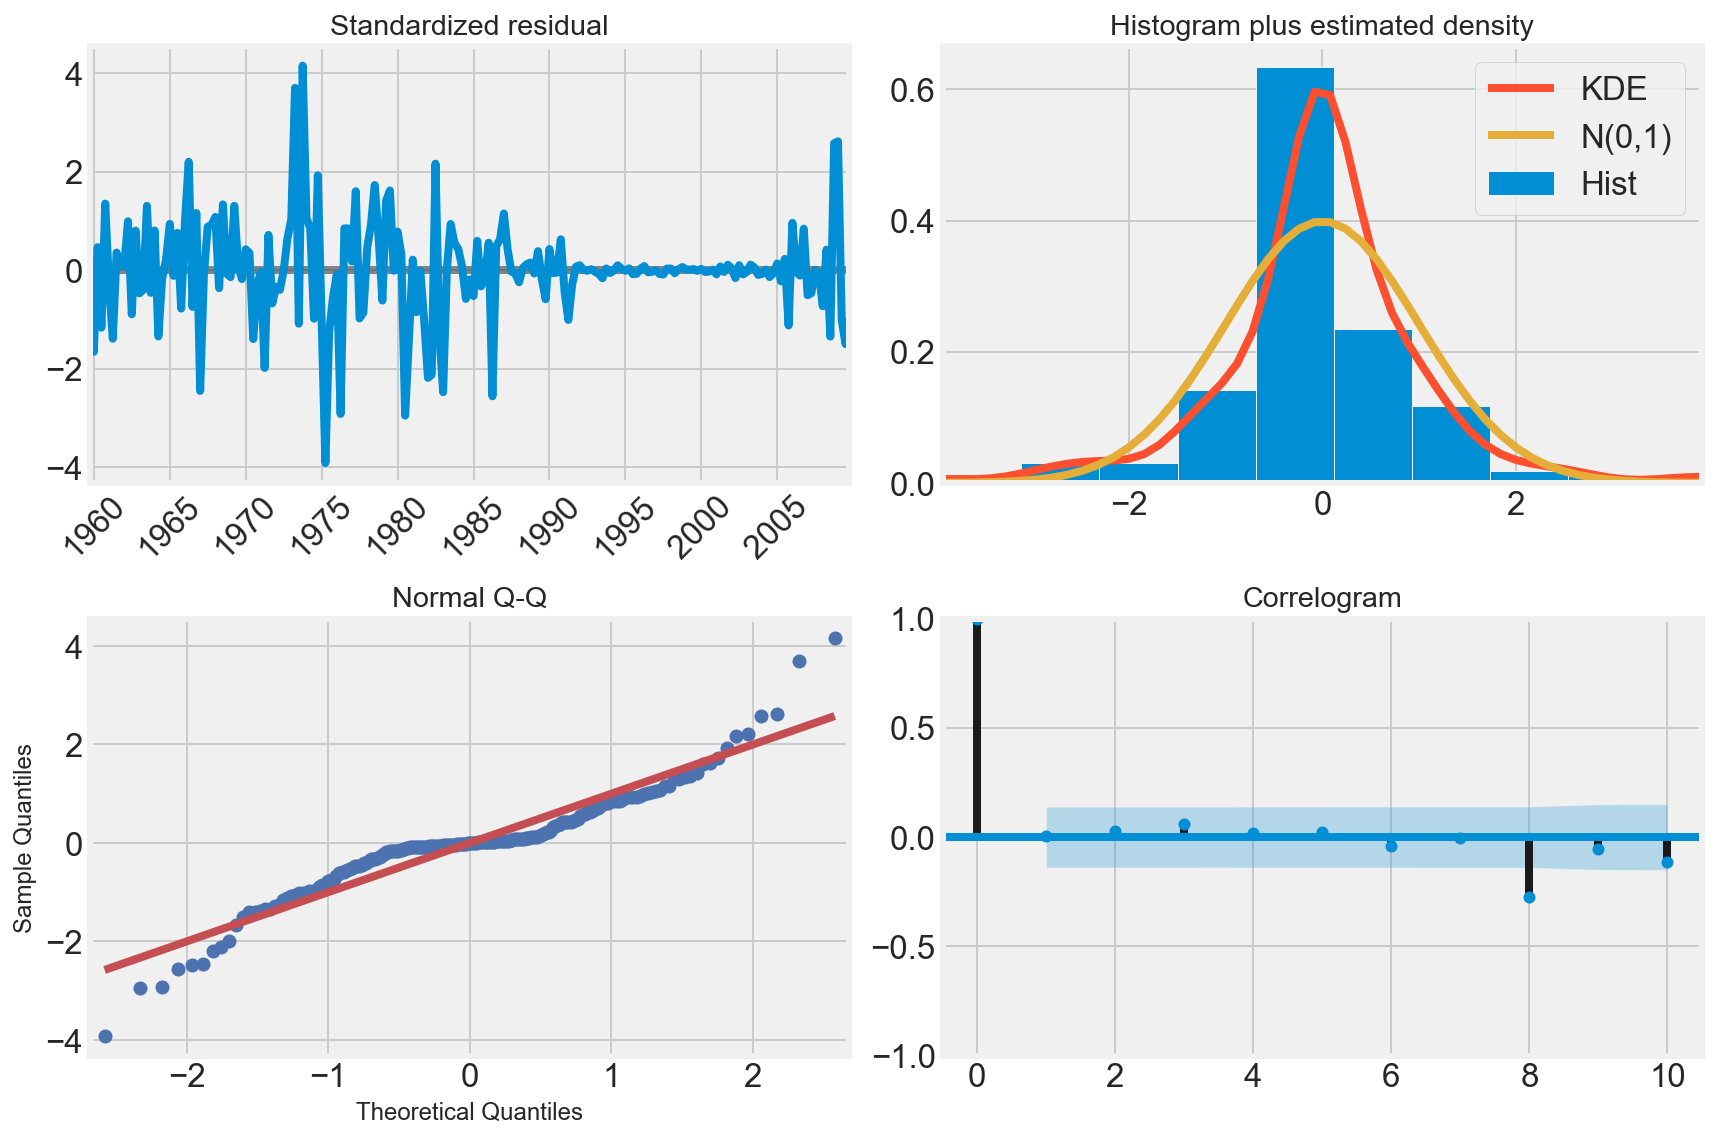

In [27]:
diag_plot = results.plot_diagnostics(1, figsize=(12, 8))
diag_plot.axes[0].tick_params(axis='x', labelrotation=45)
plt.tight_layout()
plt.show()

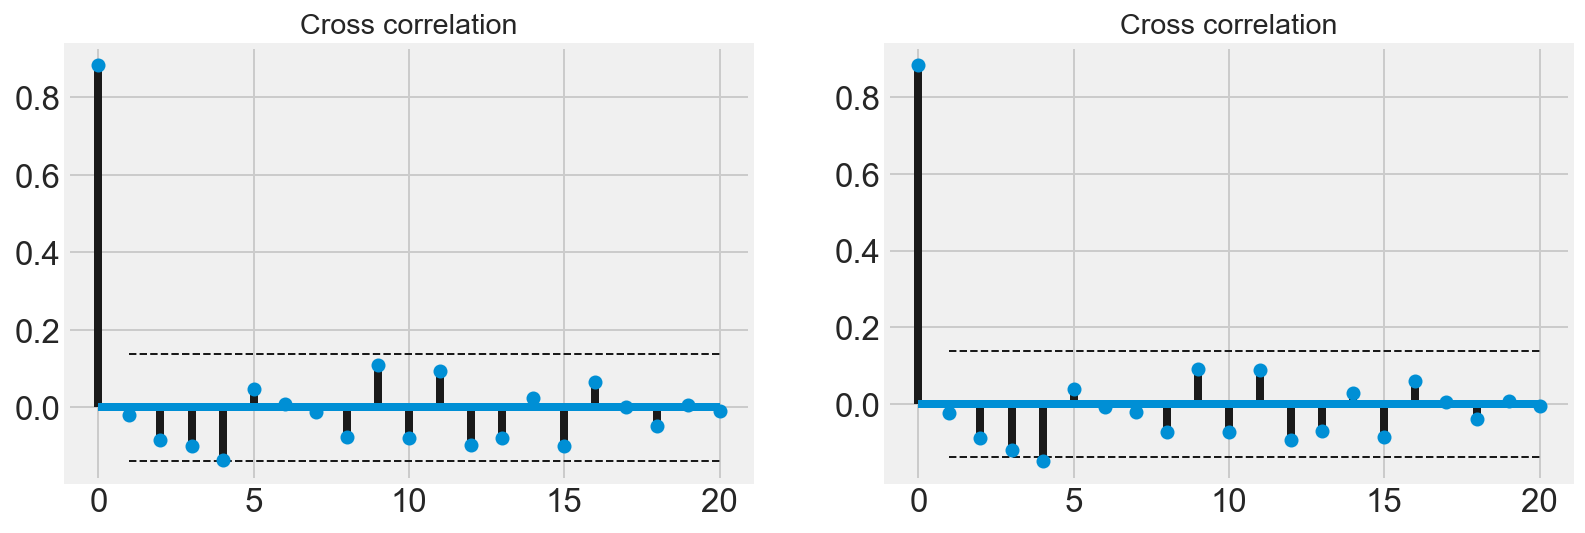

In [28]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 4))
ax[0].stem(ccf(results.resid['cpi'], results.resid['infl'])[:21], use_line_collection=True, linefmt='k', basefmt='')
ax[0].set_title('Cross correlation')
ax[0].hlines(np.array([-1, 1])*se, 1, 20, linestyles='--', lw=1)
ax[1].stem(ccf(results.resid['infl'], results.resid['cpi'])[:21], use_line_collection=True, linefmt='k', basefmt='')
ax[1].set_title('Cross correlation')
ax[1].hlines(np.array([-1, 1])*se, 1, 20, linestyles='--', lw=1)
plt.show()

In [29]:
# forecasting
start_p = 60
forecast_end = 20
data = df_1

preds = results.predict(start=1, end=len(data), dynamic=False)

preds_dyn = results.predict(
    start=1+start_p, end=len(data)+forecast_end, dynamic=True)

In [30]:
data.shape, preds_dyn.shape, preds.shape

((201, 2), (161, 2), (201, 2))

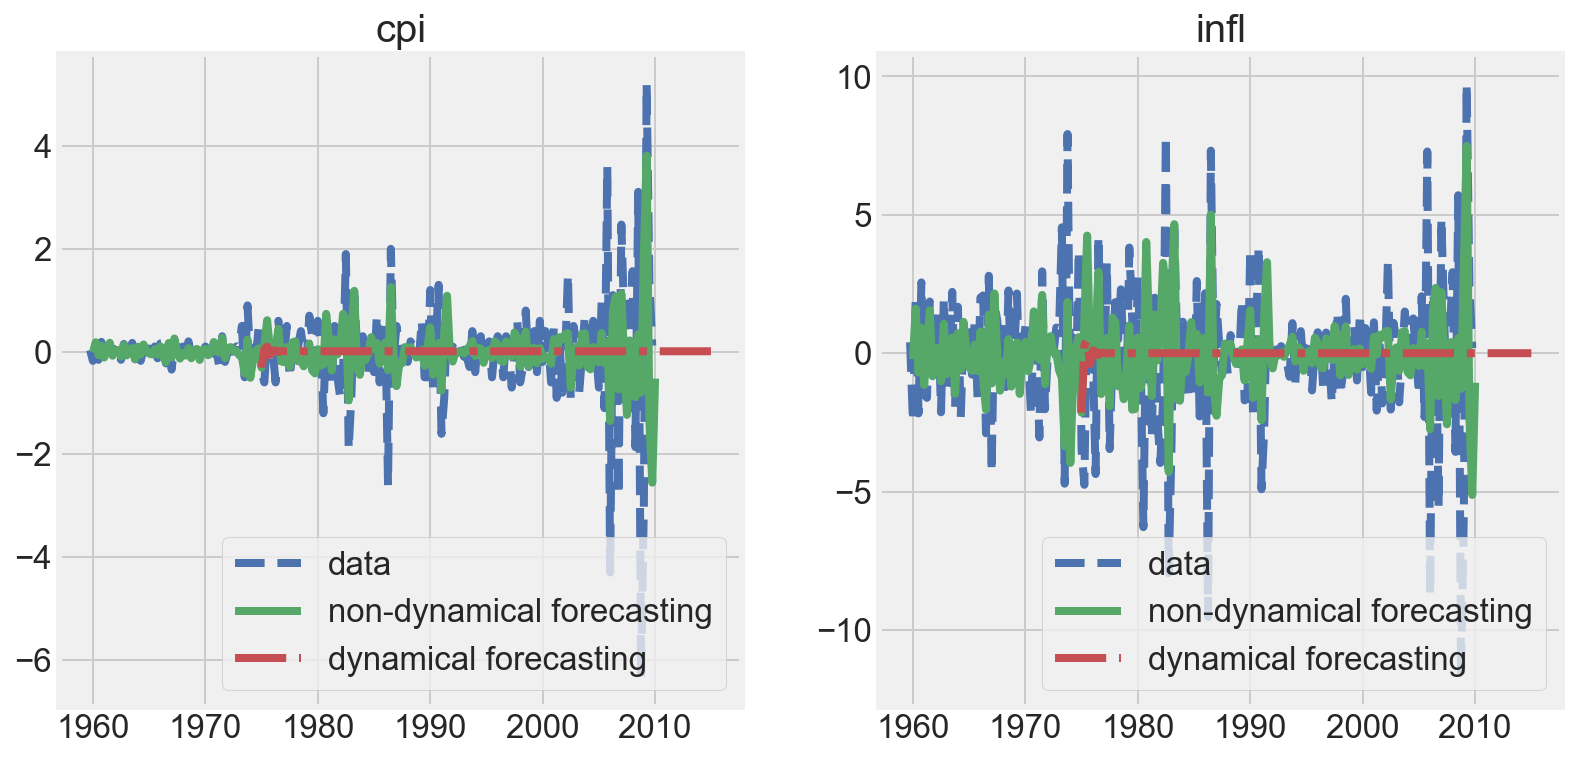

In [31]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 6))
ax[0].plot(data.cpi, 'b--', preds.cpi, 'g-', preds_dyn.cpi, 'r-.')
ax[0].legend(['data', 'non-dynamical forecasting',
              'dynamical forecasting'], loc='lower right')
ax[0].set_title('cpi', fontsize=20)
ax[1].plot(data.infl, 'b--', preds.infl, 'g-', preds_dyn.infl, 'r-.')
ax[1].legend(['data', 'non-dynamical forecasting',
              'dynamical forecasting'], loc='lower right')
ax[1].set_title('infl', fontsize=20)
plt.show()

In [32]:
np.sqrt((np.square(results.resid)).mean(axis=0))

cpi     0.849601
infl    2.294630
dtype: float64

In [33]:
1-((np.square(results.resid)).mean(axis=0))/df_1.var(ddof=0)

cpi     0.259953
infl    0.297911
dtype: float64

## Resources
---

- [Statsmodels documentation](https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.varmax.VARMAX.html)
- [Statsmodels example](http://www.statsmodels.org/dev/examples/notebooks/generated/statespace_varmax.html)